In [1]:
import earthnet_minicuber as emc
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import datetime
import folium
cmap_veg = clr.LinearSegmentedColormap.from_list('veg', ['#ffffe5','#f7fcb9','#d9f0a3','#addd8e','#78c679','#41ab5d','#238443','#006837','#004529'])

In [2]:
# Hide warnings (many since some xarray class uses some deprecated python function on 3.9)
import warnings
warnings.filterwarnings('ignore')

In [23]:
## Locations of interest
# "lon_lat": (43.598946, 3.087414), # Baidoa
# "lon_lat": (9.920089, 2.936115), # Kribi

specs = {
    "lon_lat": (43.598946, 3.087414), # center pixel
    "xy_shape": (256, 256), # width, height of cutout around center pixel
    "resolution": 10, # in meters.. will use this on a local UTM grid..
    "time_interval": "2021-01-01/2021-01-31",
    "providers": [
        {
            "name": "s2",
            "kwargs": {"bands": ["B02", "B03", "B04", "B8A"], "best_orbit_filter": True, "five_daily_filter": False, "brdf_correction": True, "cloud_mask": True, "aws_bucket": "planetary_computer"}
        },
        # {
        #     "name": "s1",
        #     "kwargs": {"bands": ["vv", "vh"], "speckle_filter": True, "speckle_filter_kwargs": {"type": "lee", "size": 9}, "aws_bucket": "planetary_computer"} 
        # },
        {
            "name": "ndviclim",
            "kwargs": {"bands": ["mean", "std"]}
        },
        {
            "name": "nasa", 
            "kwargs": {}
        },
        {
            "name": "cop",
            "kwargs": {}
        },
        {
            "name": "esawc",
            "kwargs": {"bands": ["lc"], "aws_bucket": "planetary_computer"}
        },
        {
            "name": "era5gcp",
            "kwargs": {"bands": ['t2m', 'pev', 'slhf', 'ssr', 'sp', 'sshf', 'e', 'tp'], "aggregation_types": ["mean", "min", "max"], "zarrurl": "gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3"}
        }
        ]
}

In [24]:
cube = emc.load_minicube(specs, compute = True)

Loading Sentinel2 for 2021-01-01/2021-01-31
Loading ERA5_GCP for 2021-01-01/2021-01-31
Loading NDVIClim
Loading NASADEM


KeyError: 'proj:epsg'

In [5]:
cube

<xarray.Dataset> Size: 111MB
Dimensions:             (time: 31, lon: 256, lat: 256, time_clim: 12)
Coordinates:
  * time                (time) datetime64[ns] 248B 2021-01-01 ... 2021-01-31
  * lon                 (lon) float64 2kB 43.59 43.59 43.59 ... 43.61 43.61
  * lat                 (lat) float64 2kB 3.099 3.099 3.099 ... 3.076 3.076
    angle               <U7 28B 'Zenith'
  * time_clim           (time_clim) datetime64[s] 96B 1970-01-15 ... 1970-12-15
Data variables: (12/35)
    s2_SCL              (time, lat, lon) float64 16MB nan nan nan ... nan nan
    s2_mask             (time, lat, lon) float64 16MB nan nan nan ... nan nan
    s2_avail            (time) float32 124B nan 1.0 nan nan ... nan nan nan nan
    s2_B02              (time, lat, lon) float64 16MB nan nan nan ... nan nan
    s2_B03              (time, lat, lon) float64 16MB nan nan nan ... nan nan
    s2_B04              (time, lat, lon) float64 16MB nan nan nan ... nan nan
    ...                  ...
    era5land_e_max      (time) float32 124B -2.332e-06 -1.186e-06 ... -1.399e-07
    era5land_tp_max     (time) float32 124B 0.0 0.0 0.0 ... 0.0 1.863e-09 0.0
    ndviclim_mean       (time_clim, lat, lon) float64 6MB nan nan ... nan nan
    ndviclim_std        (time_clim, lat, lon) float64 6MB nan nan ... nan nan
    cop_dem             (lat, lon) float64 524kB 470.9 471.0 ... 455.4 455.5
    esawc_lc            (lat, lon) float32 262kB 20.0 20.0 20.0 ... 25.0 30.0
Attributes:
    history:  Created on 2025-09-23 10:06:42.276522 with the earthnet-minicub...

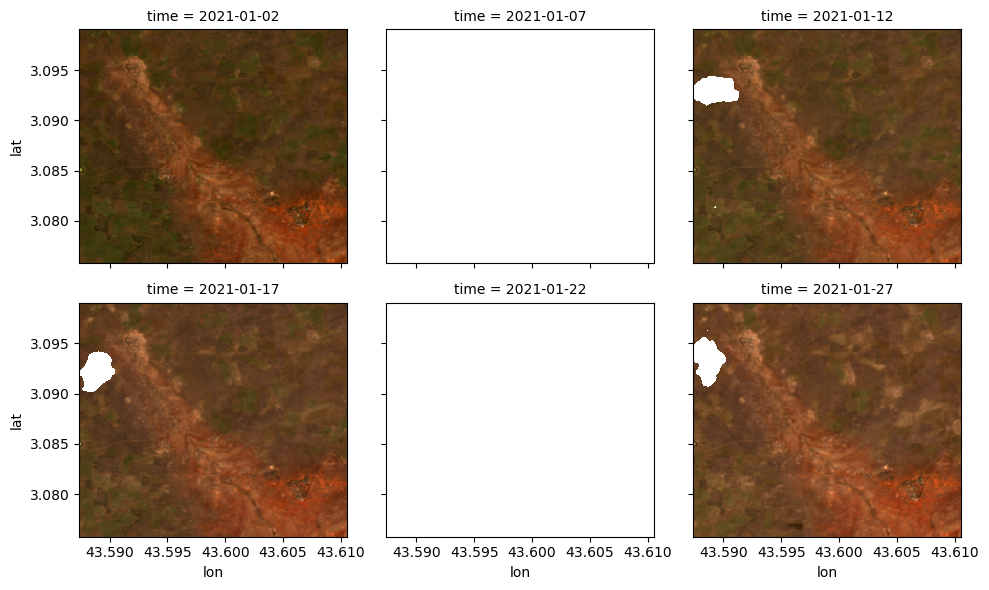

In [6]:
emc.plot_rgb(cube)

### If instead of on-the-fly, you prefer to save the minicube to disk:

In [7]:
cube = emc.Minicuber.save_minicube(specs,"minicube.nc")

# Folium plot

In [7]:
def map(minicube):
    x_min, x_max, y_min, y_max = minicube.lon[0].values, minicube.lon[-1].values, minicube.lat[-1].values, minicube.lat[0].values
    # Create map
    interactive_map = folium.Map(
        location=((y_min+y_max)/2, (x_min+x_max)/2),
        zoom_start=min(int((np.log(1000 / (x_max-x_min)) / np.log(2))), int((np.log(1000 / (y_max-y_min)) / np.log(2)))),
        tiles="http://mt1.google.com/vt/lyrs=y&z={z}&x={x}&y={y}",
        attr="Google",
        prefer_canvas=True,
    )
    
    folium.TileLayer('openstreetmap', show=False).add_to(interactive_map)
    
    # Create bounding box coordinates to overlay on map
    line_segments = [
        (y_min, x_min),
        (y_min, x_max),
        (y_max, x_max),
        (y_max, x_min),
        (y_min, x_min),
    ]

    # Add bounding box as an overlay
    interactive_map.add_child(
        folium.features.PolyLine(locations=line_segments, color="red", opacity=0.8)
    )
    #folium.PolyLine(locations=line_segments, color="red", opacity=0.8).add_to(interactive_map)
    
    return interactive_map

In [8]:
# PARAMS
S2_t = 1
# S1_t = 3

In [9]:
rgb = cube[["s2_B04", "s2_B03", "s2_B02"]].to_array("band").isel(time=S2_t).to_numpy()
rgb = np.nan_to_num(rgb, nan=0.0)
rgb = np.swapaxes(rgb, 0, 2)
rgb = np.swapaxes(rgb, 0, 1)

In [10]:
srtm = cube.srtm_dem.to_numpy()
srtm = (srtm-np.nanmin(srtm))/np.nanmax(srtm) #minmax scale
srtm = np.nan_to_num(srtm, nan=np.nanmean(srtm))

AttributeError: 'Dataset' object has no attribute 'srtm_dem'

In [11]:
# srtm = cube.srtm_dem.to_numpy()
# srtm = (srtm-np.nanmin(srtm))/np.nanmax(srtm) #minmax scale
# srtm = np.nan_to_num(srtm, nan=np.nanmean(srtm))

mask = cube["s2_mask"].isel(time=S2_t).where(lambda x: x>0).to_numpy()
mask = np.nan_to_num(mask, nan=0.0)

# s1 = (4 * cube.s1_vh / (cube.s1_vh + cube.s1_vv)).isel(time=S1_t).to_numpy()
# s1 = np.nan_to_num(s1, nan=0.0)

lc = cube.esawc_lc.to_numpy()
lc = np.nan_to_num(lc, nan=0.0)

ndvi_clims=[]
for i in range(12):
    clim = cube.ndviclim_mean.isel(time_clim=i).to_numpy()
    clim = np.nan_to_num(clim, nan=0.0)
    month = datetime.datetime.strptime(str(i+1), "%m").strftime("%b")
    ndvi_clims.append({"month": month, "ndvi_mean": clim})

In [ ]:
# s1 = (4 * cube.s1_vh / (cube.s1_vh + cube.s1_vv)).isel(time=S1_t).to_numpy()
# s1 = np.nan_to_num(s1, nan=0.0)

In [12]:
lc = cube.esawc_lc.to_numpy()
lc = np.nan_to_num(lc, nan=0.0)

In [13]:
ndvi_clims=[]
for i in range(12):
    clim = cube.ndviclim_mean.isel(time_clim=i).to_numpy()
    clim = np.nan_to_num(clim, nan=0.0)
    month = datetime.datetime.strptime(str(i+1), "%m").strftime("%b")
    ndvi_clims.append({"month": month, "ndvi_mean": clim})


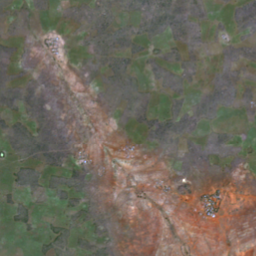
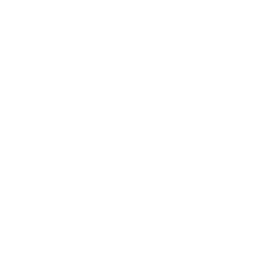
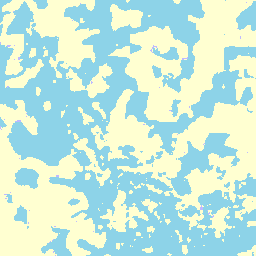
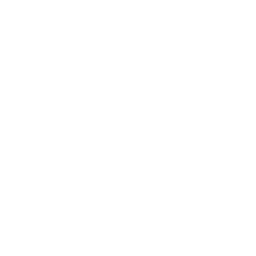
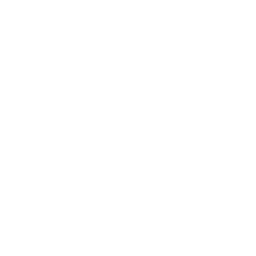
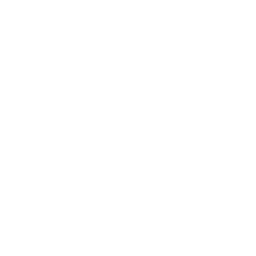
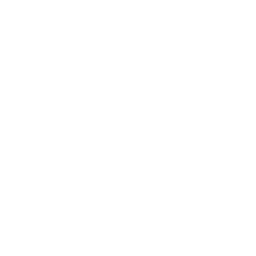
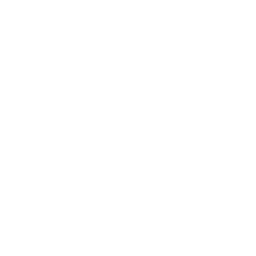
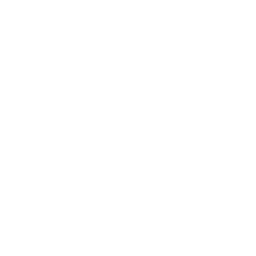
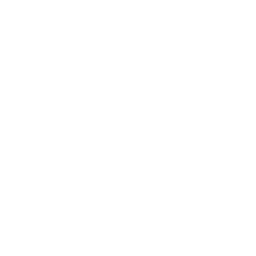
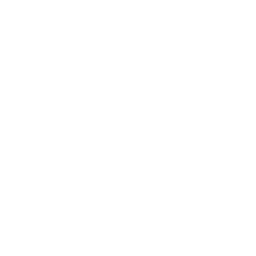
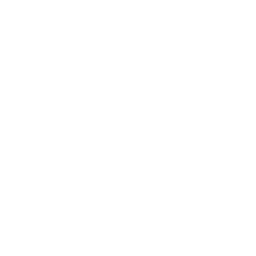
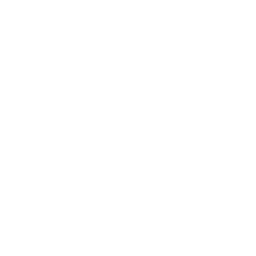
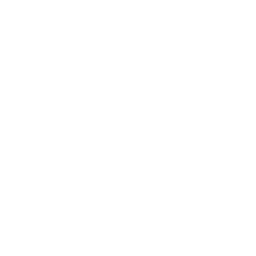
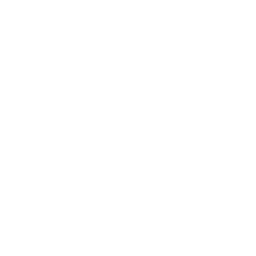

In [15]:
interactive_map = map(cube)

bounds = [[float(cube.lat[-1].values), float(cube.lon[0].values)], [float(cube.lat[0].values), float(cube.lon[-1].values)]]

# Add RGB layer
folium.raster_layers.ImageOverlay(
    image=rgb,
    bounds=bounds,
    mercator_project=True,
    name="Sentinel 2 RGB",
    opacity=0.95,
).add_to(interactive_map)

# Add cloud layer
folium.raster_layers.ImageOverlay(
    image=mask,
    bounds=bounds,
    mercator_project=True,
    name="S2 Mask",
    colormap = lambda x: (1, x/10, -x/2, x),
).add_to(interactive_map)

# # Add S1
# folium.raster_layers.ImageOverlay(
#     image=s1,
#     bounds=bounds,
#     mercator_project=True,
#     name="S1",
#     opacity=1,
#     show=False,
#     colormap = cmap_veg,
# ).add_to(interactive_map)

# # Add SRTM
# folium.raster_layers.ImageOverlay(
#     image=srtm,
#     bounds=bounds,
#     mercator_project=True,
#     name="SRTM",
#     opacity=0.75,
#     show=False,
#     colormap = plt.get_cmap("terrain"),
# ).add_to(interactive_map)

# Add ESA-WC
folium.raster_layers.ImageOverlay(
    image=lc/255,
    bounds=bounds,
    mercator_project=True,
    name="ESA WorldCover",
    opacity=0.8,
    show=False,
    colormap = plt.get_cmap("Set3"),
).add_to(interactive_map)

# Add NDVI Climatology
for clim in ndvi_clims:
    folium.raster_layers.ImageOverlay(
        image=clim['ndvi_mean'],
        bounds=bounds,
        mercator_project=True,
        name=f"NDVI {clim['month']}",
        opacity=0.9,
        show=False,
        colormap = cmap_veg,
    ).add_to(interactive_map)
    
folium.map.LayerControl(position='topright', collapsed=False, autoZIndex=True).add_to(interactive_map)

interactive_map

# Other Plots

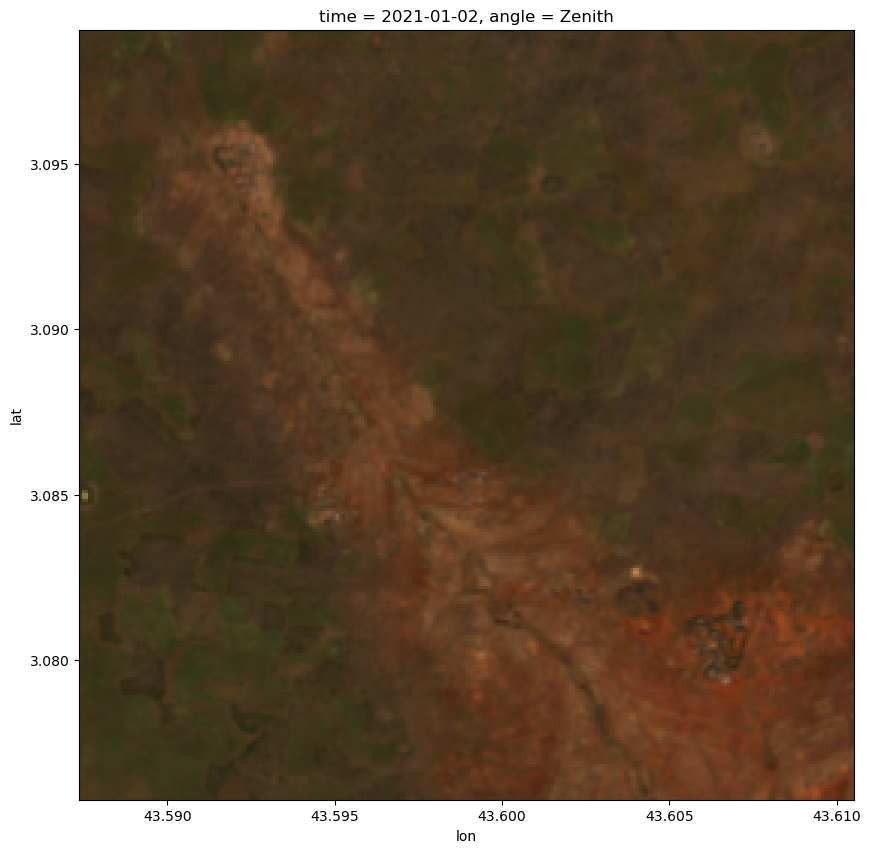

In [16]:
rgb_brightness_scaling=3

(cube[["s2_B04", "s2_B03", "s2_B02"]].to_array("band").isel(time = S2_t) * rgb_brightness_scaling).plot.imshow(rgb="band", figsize = (10, 10))

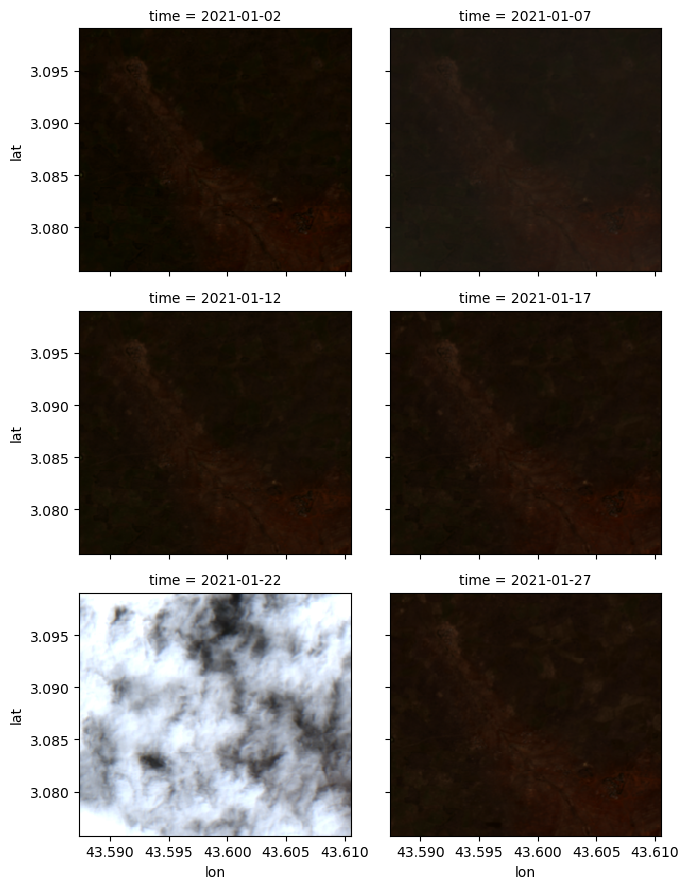

In [17]:
rgb_brightness_scaling=3
(cube[["s2_B04", "s2_B03", "s2_B02"]].to_array("band").isel(time = ~np.isnan(cube.s2_B02.isel(lat = 0, lon = 0).values)) * rgb_brightness_scaling).plot.imshow(rgb = "band", col = "time", col_wrap = 2, robust = True)

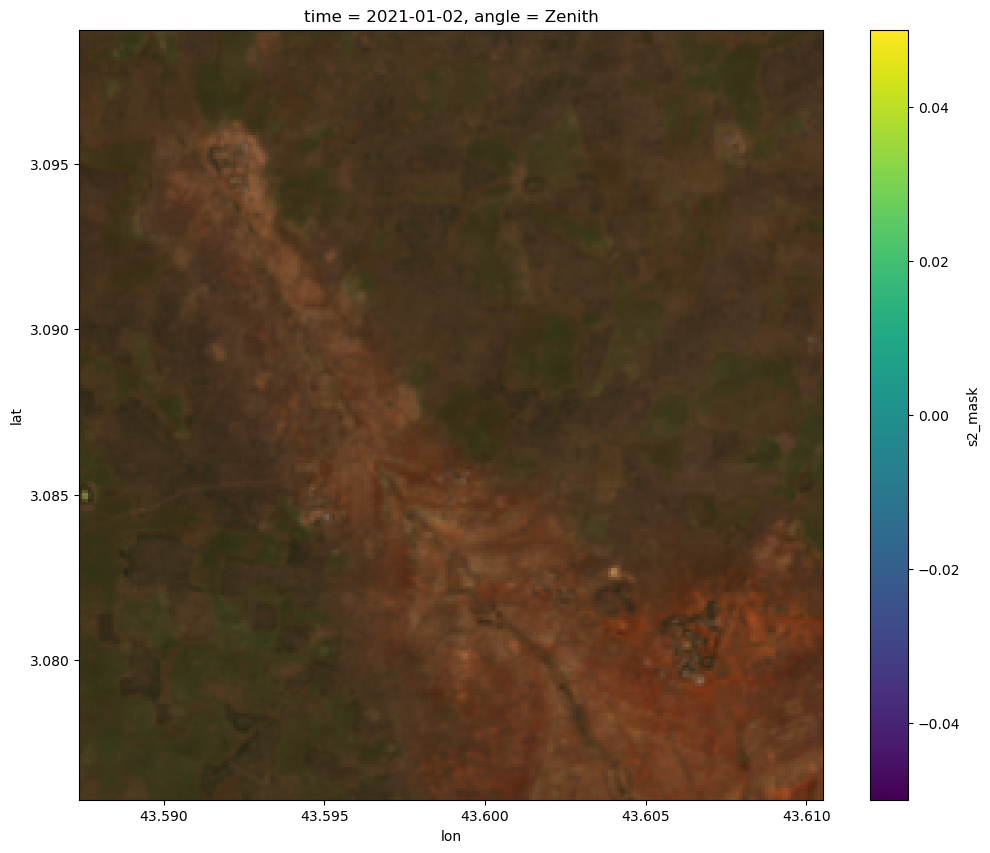

In [18]:
(cube[["s2_B04", "s2_B03", "s2_B02"]].to_array("band").isel(time = S2_t)*rgb_brightness_scaling).plot.imshow(rgb="band", figsize=(12,10))
cube["s2_mask"].isel(time=S2_t).where(lambda x: x>0).plot.imshow(ax = plt.gca())

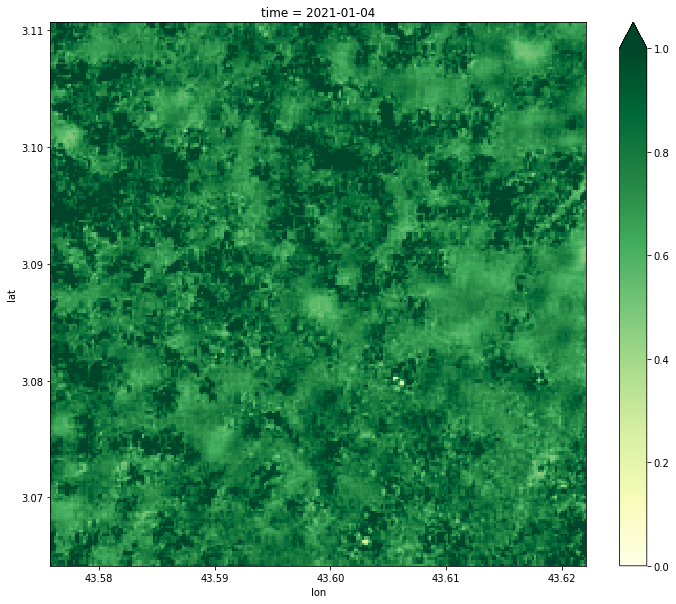

In [ ]:
# (4 * cube.s1_vh / (cube.s1_vh + cube.s1_vv)).isel(time=S1_t).plot.imshow(vmin = 0, vmax = 1,cmap = cmap_veg, figsize = (12, 10))

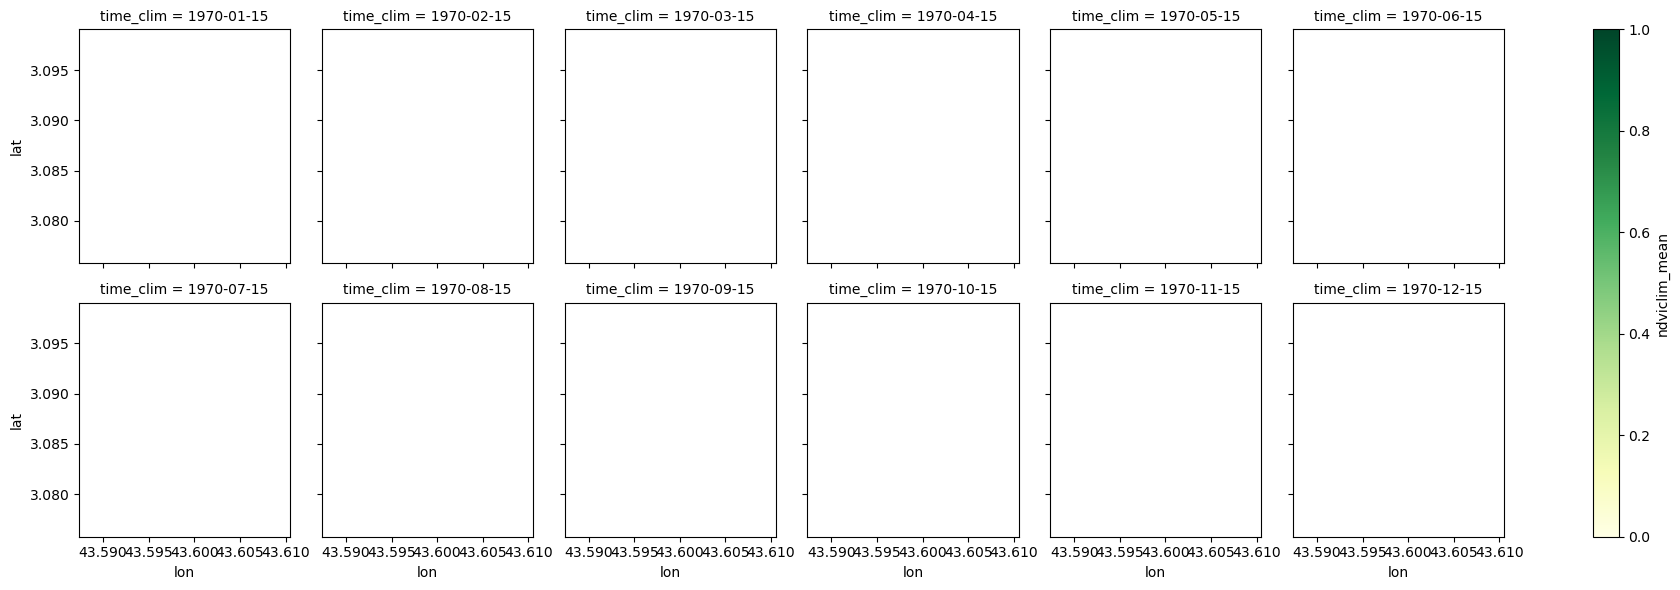

In [19]:
cube.ndviclim_mean.plot.imshow(col = "time_clim", col_wrap = 6, cmap = cmap_veg, vmin = 0, vmax = 1)

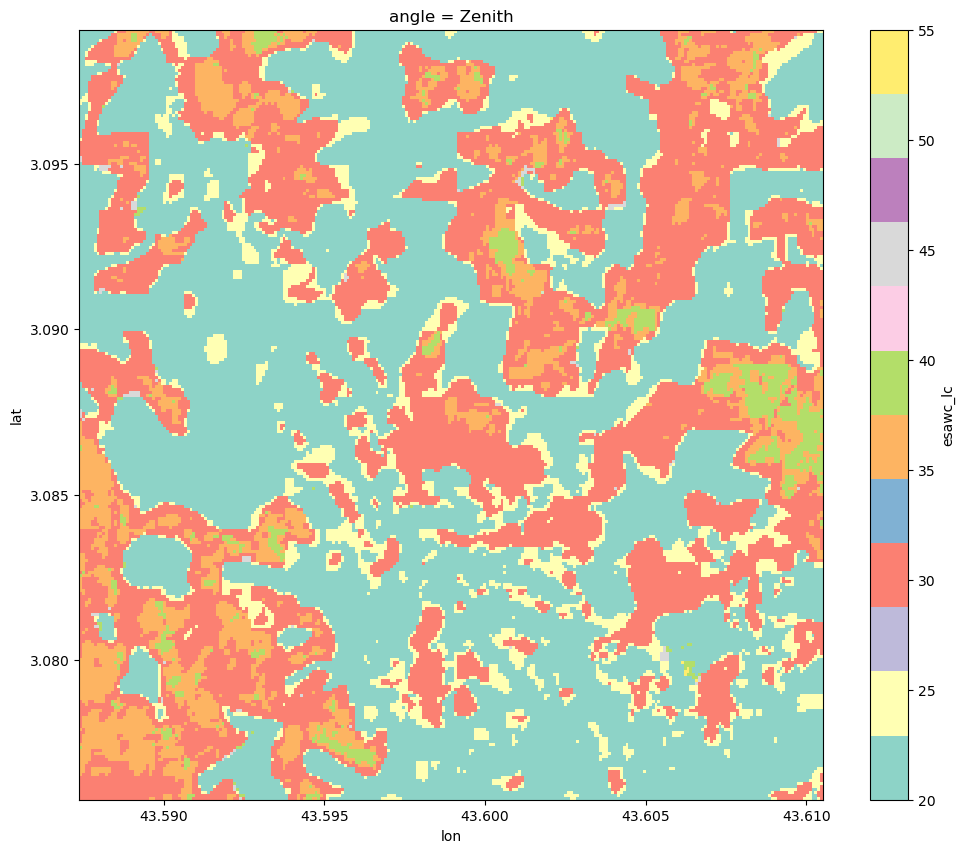

In [20]:
cube.esawc_lc.plot(cmap="Set3", figsize = (12, 10))

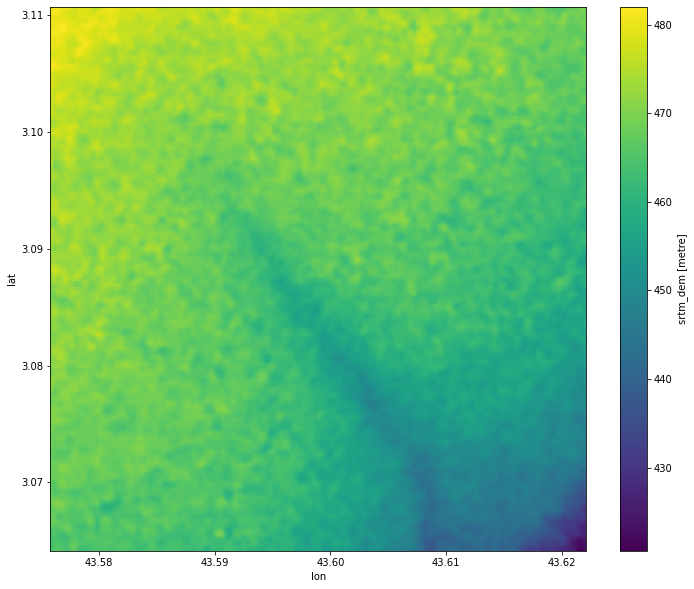

In [22]:
cube.srtm_dem.plot.imshow(figsize = (12, 10))

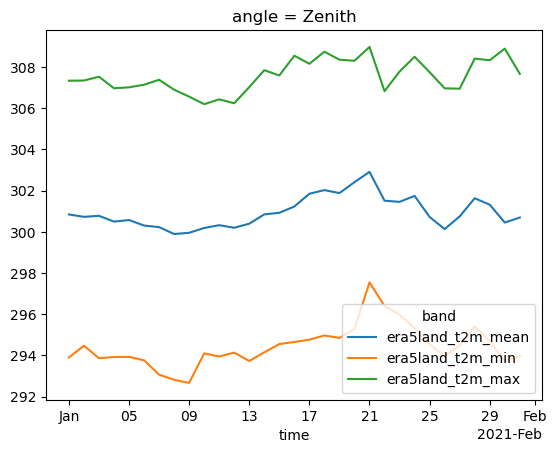

In [22]:
cube[["era5land_t2m_mean","era5land_t2m_min","era5land_t2m_max"]].to_array("band").plot(hue = "band")